In [2]:
import keras.models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from src.functions import initializers as ci # i.e., custom initializers
from src.functions.layers import ActivLin1D
from src.functions import activation_parameters as ap
from src.utils import data_handler as dh
import matplotlib.pyplot as plt

# Script to compare the outputs of the python and C++ inverse models to verify correctness

## Simple test

In [4]:
# Model save path:
inv_save_path = '/Users/francescomaraschin/Library/Mobile Documents/com~apple~CloudDocs/Universtiy/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/inverse_model/inverse_model.h5'
inverse_model = tf.keras.models.load_model(filepath=inv_save_path,
                                            custom_objects={
                                                'MyInitializer': ci.MyInitializer,
                                                'ActivLin1D': ActivLin1D
                                            })

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-19 17:38:04.432074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-19 17:38:04.433541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Inputs to NN:

vel_1 = np.array([[1,0.5,0,0,0,0,0,0,0,0]] , dtype='float32')
acc_1 = np.array([[1,0.5,0,0,0,0,0,0,0,0]] , dtype='float32')
in_1 = [vel_1 , acc_1]

In [6]:
# Calculate the predicted pedal from the python model
py_cal_pedal = inverse_model.predict(in_1)
py_cal_pedal

2023-05-19 17:38:10.315921: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-19 17:38:10.458749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 974ms/step


array([[0.4899919]], dtype=float32)

## Python Inverse Model Outputs Complex Test

In [7]:
# Model save path:
inv_save_path = '/Users/francescomaraschin/Library/Mobile Documents/com~apple~CloudDocs/Universtiy/IntelligentVehicles/LongitudinalControllerNN/Data/trained_models/inverse_model/inverse_model.h5'

inverse_model = tf.keras.models.load_model(filepath=inv_save_path,
                                            custom_objects={
                                                'MyInitializer': ci.MyInitializer,
                                                'ActivLin1D': ActivLin1D
                                            })

In [8]:
# Reshape and split data
inverse_dataset_path = '/Users/francescomaraschin/Library/Mobile Documents/com~apple~CloudDocs/Universtiy/IntelligentVehicles/LongitudinalControllerNN/Data/csv/inverse.csv'
inverse_dataset = dh.load_csv(inverse_dataset_path)
train_data, valid_data, time = dh.window_data(dataset=inverse_dataset,
                                              input_labels=['acceleration',
                                                            'velocity'],
                                              output_labels=['pedal'],
                                              input_window=10,
                                              output_window=1,
                                              batch_size=100,
                                              validation_split=0.3)

In [9]:
print(len(train_data[0]))
acc = train_data[0][0]
vel = train_data[0][1]

print(vel)

2
[[0.00256138 0.00517152 0.00783183 ... 0.01133367 0.0115318  0.01173044]
 [0.00517152 0.00783183 0.01054193 ... 0.0115318  0.01173044 0.01192831]
 [0.00783183 0.01054193 0.01073934 ... 0.01173044 0.01192831 0.01212618]
 ...
 [0.11670884 0.11769605 0.11868322 ... 0.12361845 0.12460537 0.12559225]
 [0.11769605 0.11868322 0.11967035 ... 0.12460537 0.12559225 0.12657909]
 [0.11868322 0.11967035 0.12065743 ... 0.12559225 0.12657909 0.12756588]]


In [10]:
# Calculate the predicted pedal from the python model
py_calculated_pedal = inverse_model.predict(train_data[0])

2023-05-19 17:40:35.612598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 2s 7ms/step


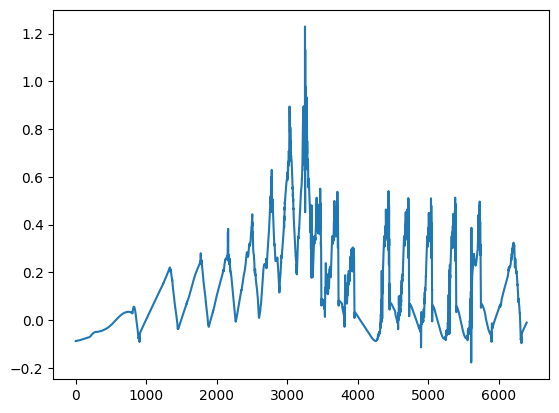

In [11]:
# plot
plt.plot(py_calculated_pedal)

## C++ model

In [12]:
# Need to make two csv files that contained the windowed velocities and accelerations.
acceleration = train_data[0][0]
velocity = train_data[0][1]
# noinspection PyTypeChecker
pd.DataFrame(acceleration).to_csv("/Users/francescomaraschin/Library/Mobile Documents/com~apple~CloudDocs/Universtiy/IntelligentVehicles/LongitudinalControllerNN/NN_CPP_Testing/test_data/acceleration.csv",
                                  header=None,
                                  index=None ,
                                  lineterminator = '\n'
                                  )
# noinspection PyTypeChecker
pd.DataFrame(velocity).to_csv("/Users/francescomaraschin/Library/Mobile Documents/com~apple~CloudDocs/Universtiy/IntelligentVehicles/LongitudinalControllerNN/NN_CPP_Testing/test_data/velocity.csv",
                              header=None,
                              index=None ,
                              lineterminator = '\n'
                              )

In [13]:
# After elaboration in the C++ network we have a CSV file containing the output of the C++ inverse NN model.
# Load this csv:

cpp_pedal_path = '/Users/francescomaraschin/Library/Mobile Documents/com~apple~CloudDocs/Universtiy/IntelligentVehicles/LongitudinalControllerNN/NN_CPP_Testing/cmake-build-debug/pedal_out_cpp.csv'
cpp_calculated_pedal = pd.read_csv(cpp_pedal_path)

# Remove weird NaN column
cpp_calculated_pedal = cpp_calculated_pedal.drop(columns='Unnamed: 1')

In [14]:
cpp_calculated_pedal

,-0.105119
0,-0.109792
1,-0.116651
2,-0.121264
3,-0.121380
4,-0.121501
...,...
6394,0.001738
6395,0.001772
6396,0.001811
6397,0.001852


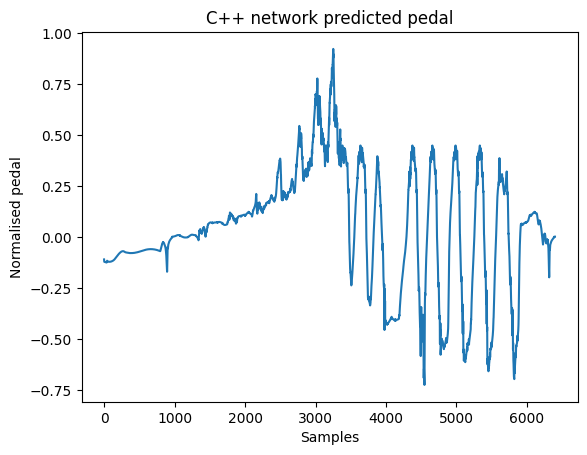

In [17]:
plt.plot(cpp_calculated_pedal)
plt.title('C++ network predicted pedal')
plt.xlabel('Samples')
plt.ylabel('Normalised pedal')
plt.savefig('/Users/francescomaraschin/Desktop/CPP_Model_Results.svg')